In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 0. Ładowanie danych do zadania

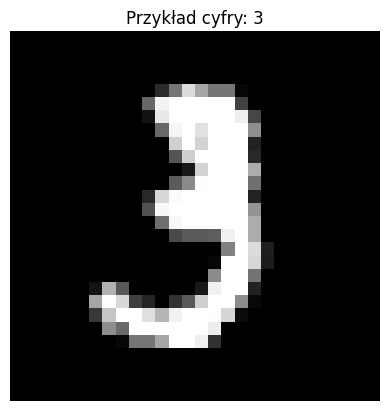

Kształt tensora: (60000, 28, 28)


In [39]:
# ładowanie zbioru danych
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

n = 10

plt.imshow(x_train[n], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[n]}")
plt.axis('off')
plt.show()

print(f"Kształt tensora: {x_train.shape}")

#1. Baseline model

Z tym może być trochę zabawy, użyję modelu drzew decyzyjnych z poprzedniego zadania.

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# przekształcanie danych

batch_size = 2000

x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

model = DecisionTreeClassifier(max_depth=7, random_state=42)
model.fit(x_train_reshaped[:batch_size], y_train[:batch_size]) # uczenie
y_pred = model.predict(x_test_reshaped)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       980
           1       0.91      0.90      0.90      1135
           2       0.59      0.73      0.65      1032
           3       0.59      0.62      0.60      1010
           4       0.63      0.67      0.65       982
           5       0.49      0.63      0.55       892
           6       0.79      0.54      0.64       958
           7       0.78      0.80      0.79      1028
           8       0.74      0.57      0.65       974
           9       0.63      0.59      0.61      1009

    accuracy                           0.69     10000
   macro avg       0.70      0.68      0.69     10000
weighted avg       0.70      0.69      0.69     10000



Accuracy: 0.69
To nie jest skuteczność, której szukamy

Teraz próba z regresją logistyczną

In [41]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train_reshaped[:batch_size], y_train[:batch_size]) # uczenie
y_pred = model.predict(x_test_reshaped)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.83      0.88      0.85      1032
           3       0.85      0.81      0.83      1010
           4       0.86      0.87      0.86       982
           5       0.75      0.81      0.78       892
           6       0.90      0.88      0.89       958
           7       0.87      0.88      0.87      1028
           8       0.82      0.75      0.78       974
           9       0.83      0.81      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Accuracy: 0.86.

Żeby użyć tego modelu musiałem zmniejszyć rozmiar próbki treningowej, bo bez tego napotykaliśmy na błąd zbyt wielu iteracji. Tutaj skuteczność jest większa, ale nieidealna i baaaardzo dużo czekania.

# 2. Model NN

Będziemy używać danych po przekształceniu

In [42]:
# sprawdzamy ilość próbek

x_train.shape

(60000, 28, 28)

In [43]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# każdy obrazek dwuwymiarowy 28x28 przekształcany jest w wektor jednowymiarowy o długości 784
# (pierwsza zmienna przechowuje ilość próbek)

batch_size = 60000 # ilość próbek

batch_size_train = 48000# ilość próbek

x_train_simple = x_train_reshaped[:batch_size_train]
y_train_simple = y_train[:batch_size_train]

x_val_simple = x_train_reshaped[batch_size_train:batch_size]
y_val_simple = y_train[batch_size_train:batch_size]

print(f"Kształt tensora 1: {x_train_simple.shape}")
print(f"Kształt tensora 2: {x_val_simple.shape}")

Kształt tensora 1: (48000, 784)
Kształt tensora 2: (12000, 784)


In [44]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = 28 * 28 # rozmiar obrazka
hidden_dim = 128 # wybrana ilość neuronów
output_dim = 10 # ilość możliwości outputu

model = Model(input_dim, hidden_dim, output_dim)

# przepuszczamy przykładowy tensor i wypisujemy kształt inputu i outputu

sample_input = x_train_simple[0:10]

output_tensor = model(torch.tensor(sample_input, dtype=torch.float32))

print(f"Kształt wejściowego tensora: {sample_input.shape}")
print(f"Kształt wyjściowego tensora z sieci: {output_tensor.shape}")

Kształt wejściowego tensora: (10, 784)
Kształt wyjściowego tensora z sieci: torch.Size([10, 10])


In [45]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels):
        if len(data) != len(labels):
            raise ValueError("Data and labels must have the same length")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = SimpleDataset(x_train_simple, y_train_simple)
val_dataset = SimpleDataset(x_val_simple, y_val_simple)

print(f"Rozmiar zbioru danych: {len(train_dataset)}")
print(f"Rozmiar zbioru danych do walidacji: {len(val_dataset)}")

Rozmiar zbioru danych: 48000
Rozmiar zbioru danych do walidacji: 12000


Prosty trening modelu

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SimpleDataset(x_test_reshaped, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

lr = 1e-3
EPOCHS = 7

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
import time

def run_epoch(loader, model, train: bool): # funkcja przejścia przez jedną epokę
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dataloader, model, train=True)
    va_loss, va_acc = run_epoch(val_dataloader, model, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/7 | train loss 49.1853 acc 0.0901 | val loss 34.8977 acc 0.1228
Ep 02/7 | train loss 35.0962 acc 0.1182 | val loss 23.7241 acc 0.2205
Ep 03/7 | train loss 23.8400 acc 0.2194 | val loss 19.4675 acc 0.3234
Ep 04/7 | train loss 19.6230 acc 0.3216 | val loss 15.8316 acc 0.4015
Ep 05/7 | train loss 15.9053 acc 0.4020 | val loss 13.6763 acc 0.4502
Ep 06/7 | train loss 13.7254 acc 0.4506 | val loss 12.2059 acc 0.4788
Ep 07/7 | train loss 12.3141 acc 0.4723 | val loss 10.1845 acc 0.5168
Czas treningu: 11.8s


# Sprawdzenie skuteczności modelu

Output po pierwszym trenowaniu przy 7 epokach wyglądał następująco:

Ep 01/7 | train loss 32.1381 acc 0.0846 | val loss 20.5923 acc 0.1808

Ep 02/7 | train loss 20.7588 acc 0.1765 | val loss 16.2530 acc 0.3494

Ep 03/7 | train loss 16.4458 acc 0.3394 | val loss 13.1035 acc 0.4984

Ep 04/7 | train loss 13.3191 acc 0.4884 | val loss 10.7444 acc 0.5850

Ep 05/7 | train loss 10.9520 acc 0.5736 | val loss 8.4325 acc 0.6440

Ep 06/7 | train loss 8.6417 acc 0.6307 | val loss 6.1404 acc 0.6857

Ep 07/7 | train loss 6.3929 acc 0.6726 | val loss 4.1212 acc 0.7148

Czas treningu: 13.7s

Możemy więc wywnioskować, że na początku z każdą epoką zmiany są ogromne, później bardzo maleją, ale progres idzie w górę. Na pewno też kosztuje nas to dużo czasu, to jest mały database więc nie widać tego aż tak dobrze.

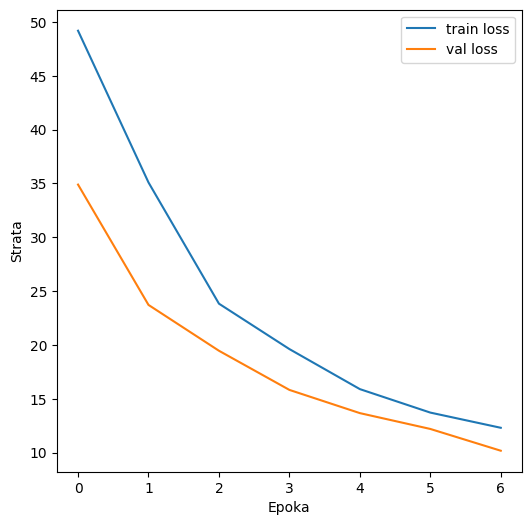

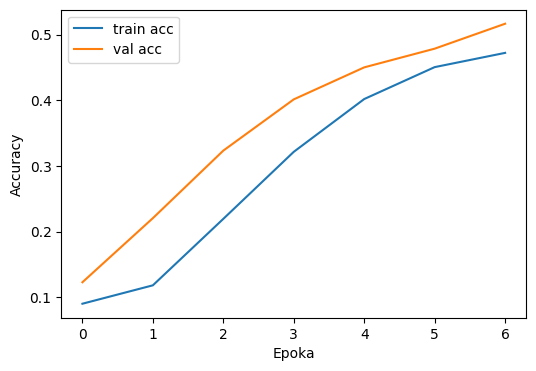

In [48]:
def plot_history(history):
    plt.figure(figsize=(6,6))
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)

Dokładność nie jest zadowalająca, tyle epok nie wystarczy, kontynuuję więc uczenie

In [49]:
EPOCHS = 5 # duża liczba epok

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dataloader, model, train=True)
    va_loss, va_acc = run_epoch(val_dataloader, model, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 10.3721 acc 0.5032 | val loss 8.0245 acc 0.5707
Ep 02/5 | train loss 8.2566 acc 0.5587 | val loss 6.4118 acc 0.6199
Ep 03/5 | train loss 6.6780 acc 0.6091 | val loss 5.4074 acc 0.6484
Ep 04/5 | train loss 5.6816 acc 0.6348 | val loss 4.5655 acc 0.6674
Ep 05/5 | train loss 4.8298 acc 0.6483 | val loss 3.6888 acc 0.6847
Czas treningu: 8.3s


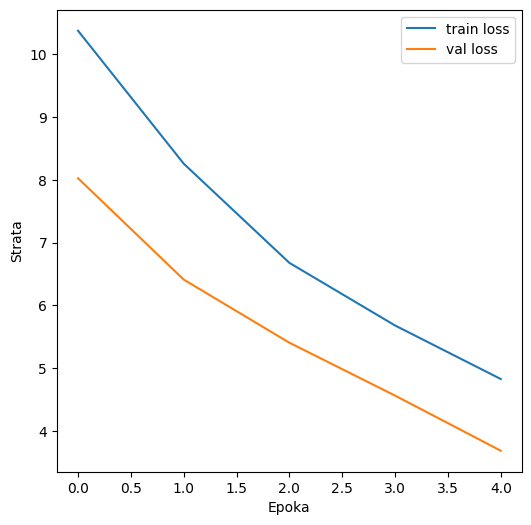

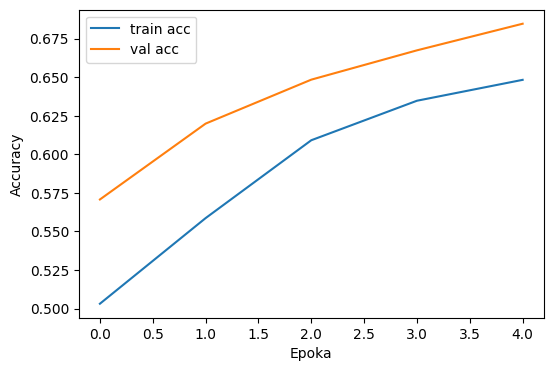

In [50]:
plot_history(history)

Dokładność sięga już 90%.

To może być dobry moment na macierz pomyłek i dalsze ulepszenia sieci.

Test accuracy: 0.6691


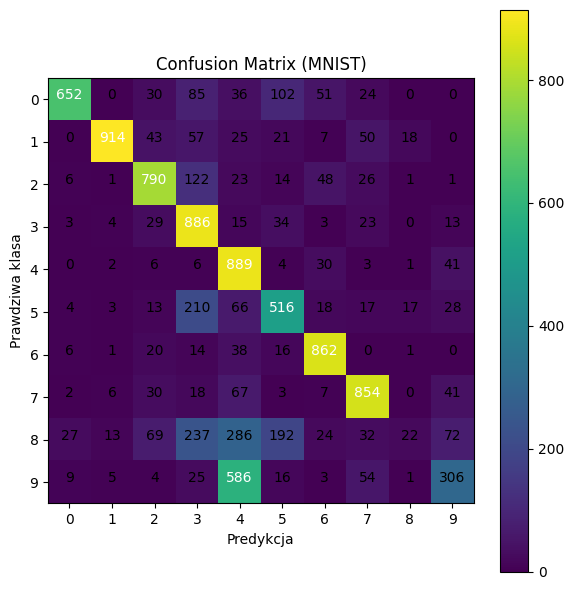

              precision    recall  f1-score   support

           0     0.9196    0.6653    0.7721       980
           1     0.9631    0.8053    0.8772      1135
           2     0.7640    0.7655    0.7648      1032
           3     0.5337    0.8772    0.6637      1010
           4     0.4377    0.9053    0.5901       982
           5     0.5621    0.5785    0.5702       892
           6     0.8186    0.8998    0.8573       958
           7     0.7886    0.8307    0.8091      1028
           8     0.3607    0.0226    0.0425       974
           9     0.6096    0.3033    0.4050      1009

    accuracy                         0.6691     10000
   macro avg     0.6758    0.6653    0.6352     10000
weighted avg     0.6814    0.6691    0.6403     10000



In [51]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(model):
  model.eval()
  all_preds, all_targets = [], []
  with torch.no_grad():
      for xb, yb in test_dataloader:
          xb = xb.to(device, non_blocking=True)
          logits = model(xb)
          preds = logits.argmax(1).cpu().numpy()
          all_preds.append(preds)
          all_targets.append(yb.numpy())

  y_pred = np.concatenate(all_preds)
  y_true = np.concatenate(all_targets)

  test_acc = (y_pred == y_true).mean()
  print(f"Test accuracy: {test_acc:.4f}")


  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest')
  plt.title("Confusion Matrix (MNIST)")
  plt.colorbar()
  tick_marks = np.arange(10)
  plt.xticks(tick_marks, tick_marks)
  plt.yticks(tick_marks, tick_marks)

  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Prawdziwa klasa')
  plt.xlabel('Predykcja')
  plt.tight_layout()
  plt.show()

  print(classification_report(y_true, y_pred, digits=4))

plot_confusion_matrix(model)

Najwięcej pomyłek występuje na linii 9-4 i 9-7, w tym duża większość z nich dotyczy nieprawidłowego wzięcia cyfry za 9.

Powodem jest najprawdopodobniej podobieństwo w kształtach tych cyfr.

In [52]:
class ChangedModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p):
        super(ChangedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_p)


        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.bn2 = nn.BatchNorm1d(hidden_size//2)
        self.dropout2 = nn.Dropout(p=dropout_p)

        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.bn3 = nn.BatchNorm1d(hidden_size//4)
        self.dropout3 = nn.Dropout(p=dropout_p)

        self.fc4 = nn.Linear(hidden_size//4, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

input_dim = 28 * 28 # rozmiar obrazka
hidden_dim = 256 # zwiększam ilość warstw ukrytych, może to poprawi dokładność
output_dim = 10 # ilość możliwości outputu
dropout_p = 0.2 # zmieniony dropout

model2 = ChangedModel(input_dim, hidden_dim, output_dim, dropout_p)

# przepuszczamy przykładowy tensor i wypisujemy kształt inputu i outputu

sample_input = x_train_simple[0:10]

output_tensor = model(torch.tensor(sample_input, dtype=torch.float32))

print(f"Kształt wejściowego tensora: {sample_input.shape}")
print(f"Kształt wyjściowego tensora z sieci: {output_tensor.shape}")

Kształt wejściowego tensora: (10, 784)
Kształt wyjściowego tensora z sieci: torch.Size([10, 10])


Tak zmieniony model próbuję ponownie przetrenować

In [53]:
EPOCHS = 5

optimizer = optim.Adam(model2.parameters(), lr=lr) # zapomniałem wstępnie o tej linijce i dalej optimizer dotyczył pierwszego modelu
# przez co dokładność nie przekroczyła 20% i zaczęła spadać XD

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dataloader, model2, train=True)
    va_loss, va_acc = run_epoch(val_dataloader, model2, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 2.3848 acc 0.0971 | val loss 2.1545 acc 0.2752
Ep 02/5 | train loss 1.8964 acc 0.4839 | val loss 2.0425 acc 0.3801
Ep 03/5 | train loss 1.6348 acc 0.6581 | val loss 1.9444 acc 0.5097
Ep 04/5 | train loss 1.4756 acc 0.7324 | val loss 1.8552 acc 0.6219
Ep 05/5 | train loss 1.3641 acc 0.7758 | val loss 1.7736 acc 0.6937
Czas treningu: 13.0s


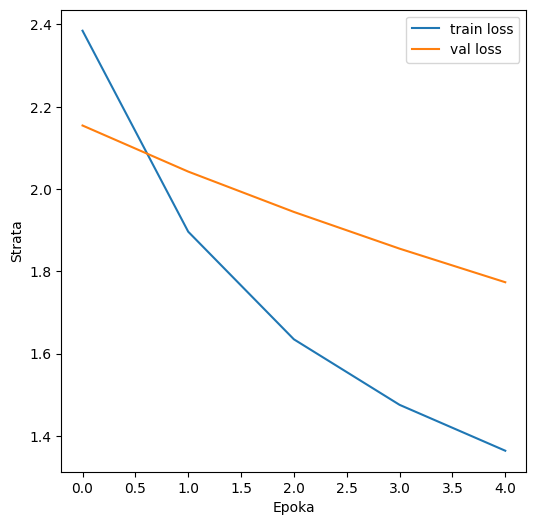

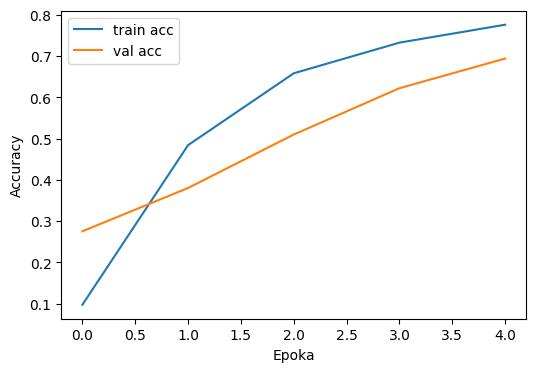

In [54]:
plot_history(history)

Dokładność sięga już 94%, widać poprawę, jednak czas uczenia zwiększył się do ponad 80 sekund.

Test accuracy: 0.6778


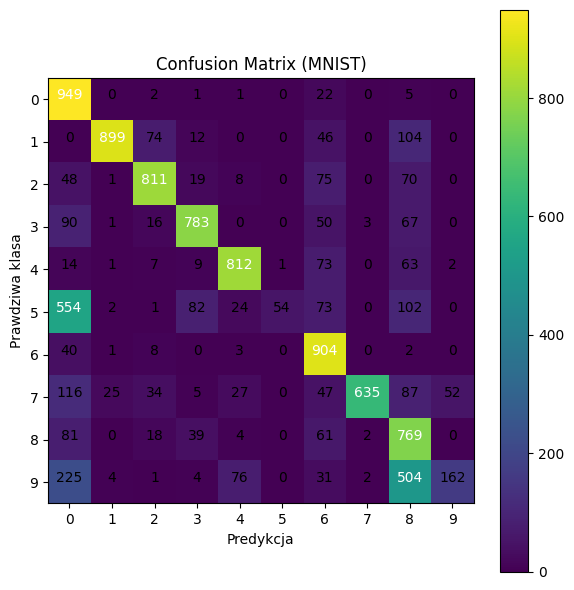

              precision    recall  f1-score   support

           0     0.4483    0.9684    0.6129       980
           1     0.9625    0.7921    0.8690      1135
           2     0.8344    0.7859    0.8094      1032
           3     0.8208    0.7752    0.7974      1010
           4     0.8503    0.8269    0.8384       982
           5     0.9818    0.0605    0.1140       892
           6     0.6541    0.9436    0.7726       958
           7     0.9891    0.6177    0.7605      1028
           8     0.4337    0.7895    0.5599       974
           9     0.7500    0.1606    0.2645      1009

    accuracy                         0.6778     10000
   macro avg     0.7725    0.6720    0.6399     10000
weighted avg     0.7755    0.6778    0.6487     10000



In [55]:
plot_confusion_matrix(model2)

Pomyłek jest znacznie mniej, występują głównie na linii 9-4, tak jak poprzednio, teraz jednak 9 są błędnie brane za 4.

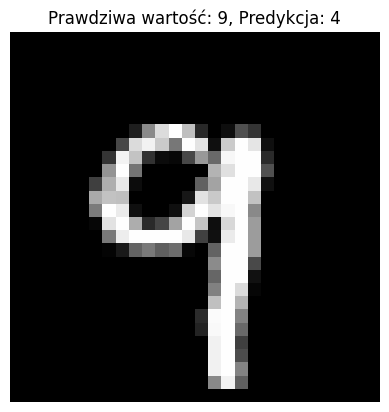

In [56]:
model2.eval()
images, labels = next(iter(test_dataloader))

a = 9 # prawdziwa wartość
b = 4 # predykcja

with torch.no_grad():
  logits = model2(images)
preds = logits.argmax(1)

# szukanie błędnej predykcji w batchu
error_idx = None
for i in range(len(images)):
  if labels[i] == a and preds[i] == b:
      error_idx = i
      break

if error_idx is not None:
  plt.imshow(images[error_idx].cpu().view(28,28), cmap='gray')
  plt.title(f"Prawdziwa wartość: {a}, Predykcja: {b}")
  plt.axis('off')
  plt.show()

Dzięki wizualizacji pomyłki możemy zauważyć faktyczne podobieństwo między tymi dwoma cyframi.

(Ale można trafić też na takie łatwo rozróżnialne)

In [57]:
import os

#zapis modelu
save_path = "mnist_cnn.pt"
torch.save(model.state_dict(), save_path)
print(f"Model zapisany do: {os.path.abspath(save_path)}")

Model zapisany do: /content/mnist_cnn.pt


Wnioski:

* Sieć neuronowa to rozwiązanie dużo skuteczniejsze od baselinowych modeli
* Zmiany dokonane między modelami 1 i 2 zwiększyły accuracy, jednak jest jeszcze daleko do 100%
* Zadowalający wynik klasyfikacji sięgałby powyżej 97% accuracy
* Dalsze uczenie tego modelu nie przyniosłoby skutków, co widać na wykresie epoch/accuracy - ma kształt funkcji logarytmicznej i zaszedł już dość daleko


---
# POPRAWKI
---

Poprawiony model, tym razem faktycznie CNN.

In [70]:
import torch.nn.functional as F

class ChangedCNN(nn.Module):
    def __init__(self, num_classes = 10, dropout_p=0.5):
        super(ChangedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model3 = ChangedCNN().to(device)

Przygotowanie danych: transformacja, umieszczenie w datasetach, dataloadery

In [71]:
# Przygotowanie danych

batch_size = 60000 # ilość próbek

batch_size_train = 48000# ilość próbek

x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)

x_train_cnn = x_train[:batch_size_train]
y_train_cnn = y_train[:batch_size_train]

x_val_cnn = x_train[batch_size_train:batch_size]
y_val_cnn = y_train[batch_size_train:batch_size]

cnn_train = SimpleDataset(x_train_cnn, y_train_cnn)
cnn_val = SimpleDataset(x_val_cnn, y_val_cnn)

cnn_test = SimpleDataset(x_test, y_test)

print(f"Rozmiar zbioru danych: {len(cnn_train)}")
print(f"Rozmiar zbioru danych do walidacji: {len(cnn_val)}")
print(f"Kształt zbioru danych treningowych: {x_train_cnn.shape}")

cnn_train_loader = DataLoader(cnn_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
cnn_val_loader = DataLoader(cnn_val, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

cnn_test_loader = DataLoader(cnn_test, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

Rozmiar zbioru danych: 48000
Rozmiar zbioru danych do walidacji: 12000
Kształt zbioru danych treningowych: (48000, 1, 28, 28)


Optimizer, monitorowanie historii i trening modelu

In [73]:
EPOCHS = 5

optimizer = optim.Adam(model3.parameters(), lr=lr)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(cnn_train_loader, model3, train=True)
    va_loss, va_acc = run_epoch(cnn_val_loader, model3, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.2569 acc 0.9235 | val loss 0.0638 acc 0.9815
Ep 02/5 | train loss 0.1626 acc 0.9523 | val loss 0.0526 acc 0.9848
Ep 03/5 | train loss 0.1368 acc 0.9599 | val loss 0.0449 acc 0.9872
Ep 04/5 | train loss 0.1160 acc 0.9665 | val loss 0.0466 acc 0.9868
Ep 05/5 | train loss 0.1128 acc 0.9673 | val loss 0.0416 acc 0.9885
Czas treningu: 353.1s


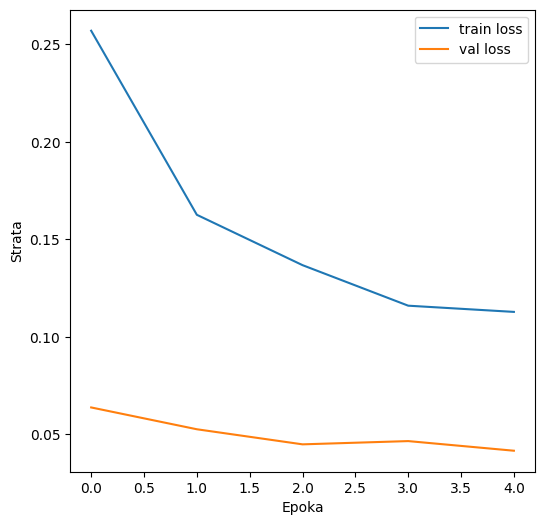

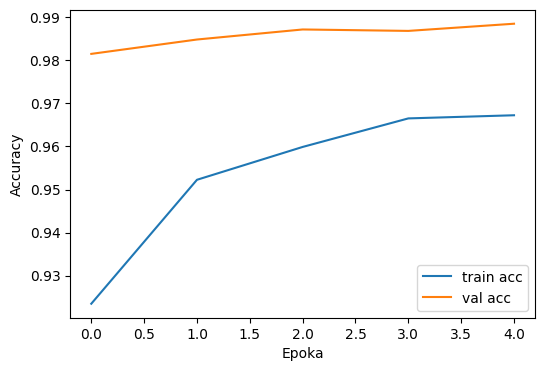

In [74]:
plot_history(history)

Tak wygląda historia po poprawkach.

In [83]:
def plot_confusion_matrix(model, test_dataloader, device):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in test_dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    test_acc = (y_pred == y_true).mean()
    print(f"Test accuracy: {test_acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (MNIST)")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Predykcja')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, digits=4))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9891


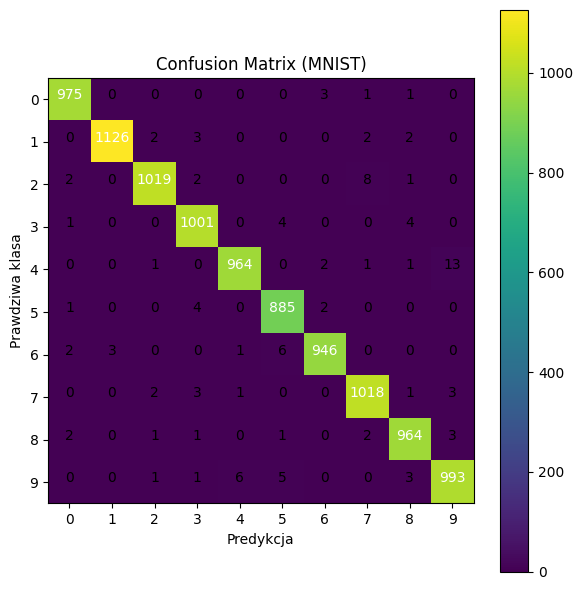

              precision    recall  f1-score   support

           0     0.9919    0.9949    0.9934       980
           1     0.9973    0.9921    0.9947      1135
           2     0.9932    0.9874    0.9903      1032
           3     0.9862    0.9911    0.9886      1010
           4     0.9918    0.9817    0.9867       982
           5     0.9822    0.9922    0.9872       892
           6     0.9927    0.9875    0.9901       958
           7     0.9864    0.9903    0.9883      1028
           8     0.9867    0.9897    0.9882       974
           9     0.9812    0.9841    0.9827      1009

    accuracy                         0.9891     10000
   macro avg     0.9890    0.9891    0.9890     10000
weighted avg     0.9891    0.9891    0.9891     10000



In [84]:
plot_confusion_matrix(model3, cnn_test_loader, device)

Dużo lepiej się to prezentuje - myślę, że teraz zadanie jest kompletne